# Utility

In [44]:
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu  # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt

import numba
from joblib import Parallel, delayed  # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation
import tempfile
import gmsh
import meshio
import itertools
import shutil  # file copying
import networkx as nx # graph representation
import os

from lxml import etree
from matplotlib.colors import to_hex

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################
from robot_utils import *
import robot_utils
help(robot_utils)

open3d :0.11.2
trimesh:3.8.19
numba  :0.52.0
Help on module robot_utils:

NAME
    robot_utils

CLASSES
    builtins.dict(builtins.object)
        Unit
        VolumeMesh
    builtins.object
        Joint
        URDF
    networkx.classes.digraph.DiGraph(networkx.classes.graph.Graph)
        RobotDescription
    
    class Joint(builtins.object)
     |  Joint(left, right, anchor, left_coord, right_coord, num_spring_per_mass=20, axis=None)
     |  
     |  Methods defined here:
     |  
     |  __init__(s, left, right, anchor, left_coord, right_coord, num_spring_per_mass=20, axis=None)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  __repr__(s)
     |      Return repr(self).
     |  
     |  toDict(s)
     |  
     |  tolist(s)
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     | 

In [45]:
########## discretization parameters ##############
# radius_poisson = float(10) # radius for the poisson sampling
radius_poisson = float(20) # radius for the poisson sampling
radius_knn = radius_poisson*np.sqrt(3)*1.4
min_radius = radius_knn*0.2
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
max_nn = int(28)
print(radius_knn)

half_joint_overlap = radius_poisson * 0
joint_overlap = half_joint_overlap*2
print(f"joint_overlap:{joint_overlap}")

# general argument
gmsh_args = [
        ("Mesh.Algorithm", 6), # 2D mesh algorithm (1: MeshAdapt, 2: Automatic, 3: Initial mesh only, 5: Delaunay, 6: Frontal-Delaunay, 7: BAMG, 8: Frontal-Delaunay for Quads, 9: Packing of Parallelograms)
        ("Mesh.Algorithm3D", 10), # 3D mesh algorithm (1: Delaunay, 3: Initial mesh only, 4: Frontal, 7: MMG3D, 9: R-tree, 10: HXT)
        ("Mesh.MeshSizeExtendFromBoundary", 0),# Extend computation of mesh element sizes from the boundaries into the interior (for 3D Delaunay, use 1: longest or 2: shortest surface edge length)
        ("Mesh.MeshSizeFromPoints", 0),# Compute mesh element sizes from values given at geometry points, defualt:1
        ("Mesh.MeshSizeFromCurvature", 0),# Automatically compute mesh element sizes from curvature,defult:0
        ("Mesh.OptimizeNetgen",0), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
        ("Mesh.OptimizeThreshold",0.5), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
#         ("Mesh.AllowSwapAngle",30), # Threshold angle (in degrees) between faces normals under which we allow an edge swap

    
        ("Mesh.VolumeEdges",1), # Display edges of volume mesh
        ("Mesh.VolumeFaces",0), # Display faces of volume mesh
        ("Mesh.SurfaceFaces",1), # Display faces of surface mesh?
        ("Mesh.Smoothing",8), # Number of smoothing steps applied to the final mesh
#         ("Mesh.SmoothNormals",0), # Smooth the mesh normals? default 0
        ("Mesh.Binary",1), # Write mesh files in binary format (if possible)
    
        ("Mesh.MinimumCirclePoints",0), # Minimum number of nodes used to mesh circles and ellipses
        ("Mesh.MinimumCurvePoints",0), # Minimum number of points used to mesh curves other than lines, circles and ellipses
        ("Mesh.MinimumElementsPerTwoPi",0), # Minimum number of elements per 2 * Pi radians when the mesh size is adapted to the curvature
        
        ("Mesh.RefineSteps",20), # Number of refinement steps in the MeshAdapt-based 2D algorithms, default:10

#         ("Geometry.Tolerance",radius_poisson*0.5),# Geometrical tolerance,default:1e-8
        ("Geometry.OCCFixDegenerated",1), # Fix degenerated edges/faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
        ("Geometry.OCCFixSmallEdges",1), # Fix small edges when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
        ("Geometry.OCCFixSmallFaces",1), # Fix small faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel, defulat:0
#         ("Geometry.OCCSewFaces",1), # Sew faces when importing STEP, IGES and BRep models with the OpenCASCADE kernel
#         ("Geometry.OCCBoundsUseStl",1), # Use STL mesh for computing bounds of OpenCASCADE shapes (more accurate, but slower)

        ("General.Verbosity",0), # Level of information printed during processing (0: no information), default:5
        ("General.Terminal",0), # Should information be printed on the terminal (if available)
#         ("Mesh.RandomSeed",0), # Seed of pseudo-random number generator
#         ("Mesh.QualitySup",0.5), # Only display elements whose quality measure is smaller than QualitySup
]

# 2D specific argument
gmsh_args_2d = [
        ("Mesh.MeshSizeMin", radius_poisson*1.4),
        ("Mesh.MeshSizeMax", radius_poisson*1.4),
] 

# 3D specific argument
gmsh_args_3d = [
        ("Mesh.MeshSizeMin", radius_poisson*1.0),
        ("Mesh.MeshSizeMax", radius_poisson*1.0),
]

gmsh_args = gmsh_args+gmsh_args_2d # combined

# # # discretize body
# # in_file_name: str = "../../mesh/soft_body_simplified.step"
# # out_file_name: str = "../../mesh/soft_body_simplified.msh"
# in_file_name: str = "../../mesh/leg_simplified.step"
# out_file_name: str = "../../mesh/leg_simplified.msh"
# vmesh,_= generateGmsh(in_file_name,out_file_name,dim=3,gui=True)
# # print(vmesh)
# vmeshSummary(vmesh)

48.497422611928556
joint_overlap:0.0


# discretization

Only need to run once

In [46]:
robot_folder = "../../mesh/v8.0/"
show_gui = False

# vertices          = 694
# surface triangle  = 1330
# tetra             = 2015
# unique tetra edges= 3372
# unique face edges = 1995
COM                 =  [14.609 -0.252 -0.304]
COM norm            = 14.614
mean edge length    = 23.07


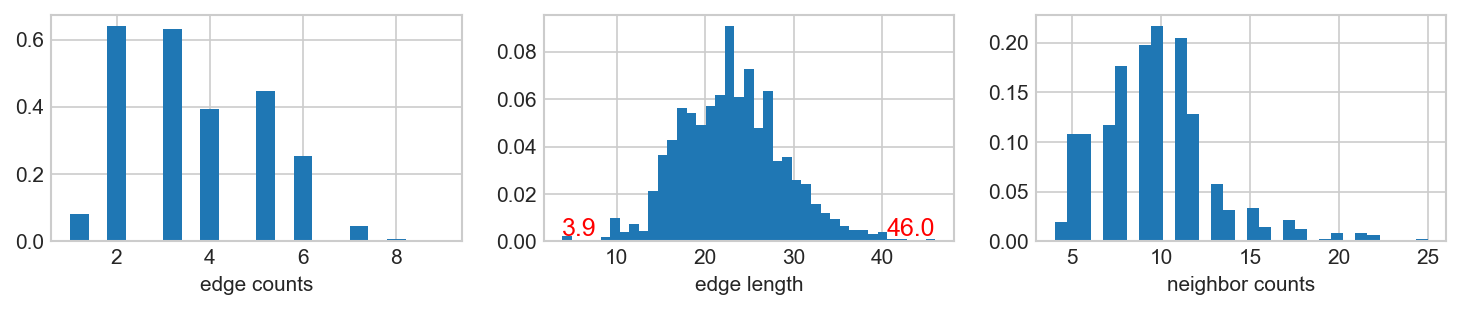

In [47]:
in_file_name: str =robot_folder+"body.step"
out_file_name: str =robot_folder+"body.msh"

vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,gui=show_gui)
vmeshSummary(vmesh)

# vertices          = 99
# surface triangle  = 176
# tetra             = 254
# unique tetra edges= 440
# unique face edges = 264
COM                 =  [50.7    0.081  0.097]
COM norm            = 50.701
mean edge length    = 25.10


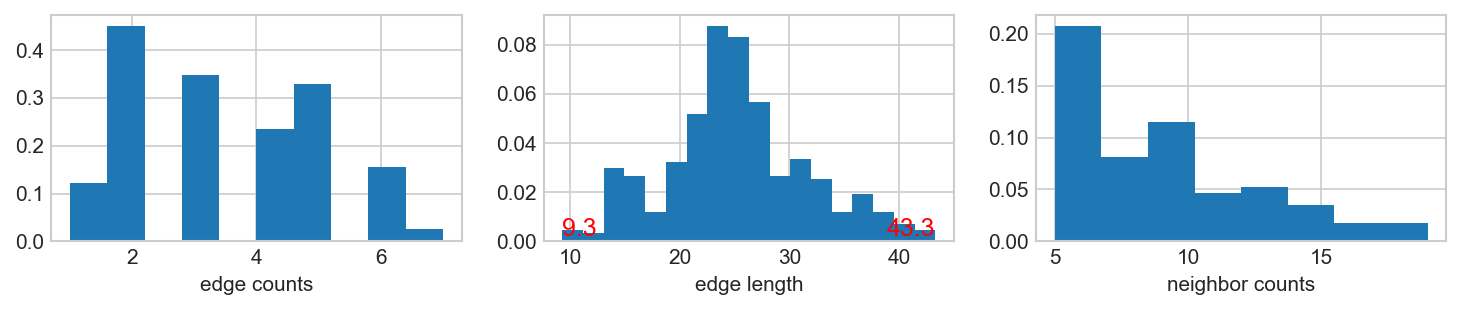

In [48]:
in_file_name: str =robot_folder+"hip.step"
out_file_name: str =robot_folder+"hip.msh"

vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,gui=show_gui)
vmeshSummary(vmesh)

# vertices          = 100
# surface triangle  = 176
# tetra             = 266
# unique tetra edges= 453
# unique face edges = 264
COM                 =  [50.362  0.058  0.208]
COM norm            = 50.362
mean edge length    = 25.01


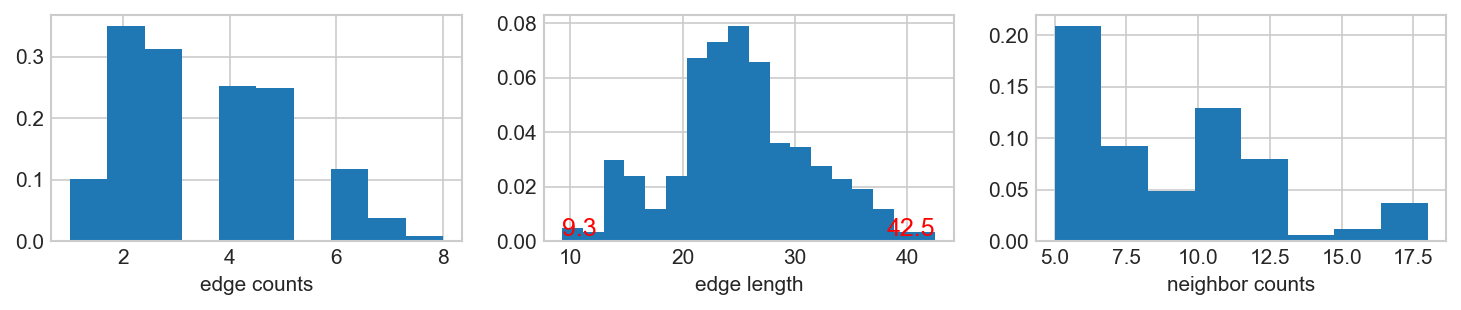

In [49]:
in_file_name: str =robot_folder+"hip.step"
out_file_name: str =robot_folder+"hip_back.msh"

vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,gui=show_gui)
vmeshSummary(vmesh)

# vertices          = 99
# surface triangle  = 176
# tetra             = 252
# unique tetra edges= 438
# unique face edges = 264
COM                 =  [50.248  0.058 -0.145]
COM norm            = 50.249
mean edge length    = 25.04


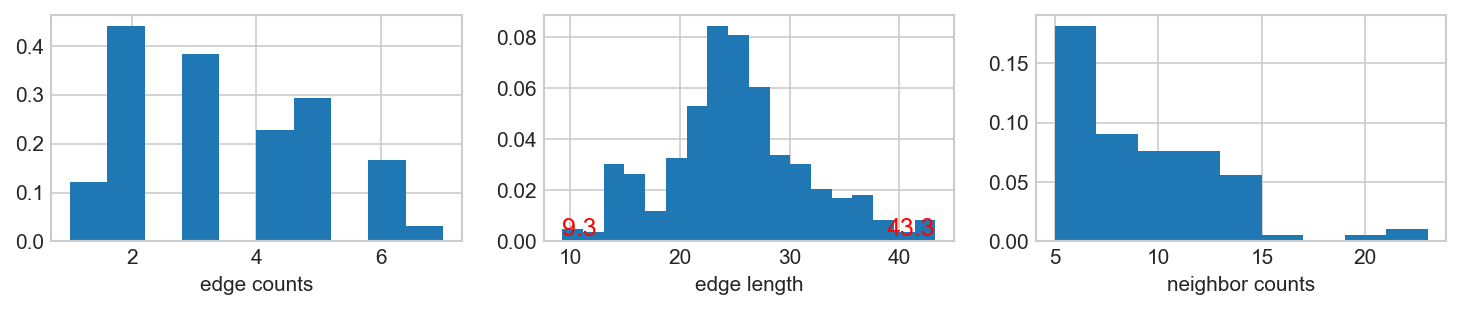

In [50]:
in_file_name: str =robot_folder+"hip.step"
out_file_name: str =robot_folder+"hip_back_mirror.msh"

vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,gui=show_gui)
vmeshSummary(vmesh)

# vertices          = 142
# surface triangle  = 266
# tetra             = 370
# unique tetra edges= 644
# unique face edges = 399
COM                 =  [ -0.031   0.075 -72.696]
COM norm            = 72.696
mean edge length    = 23.49


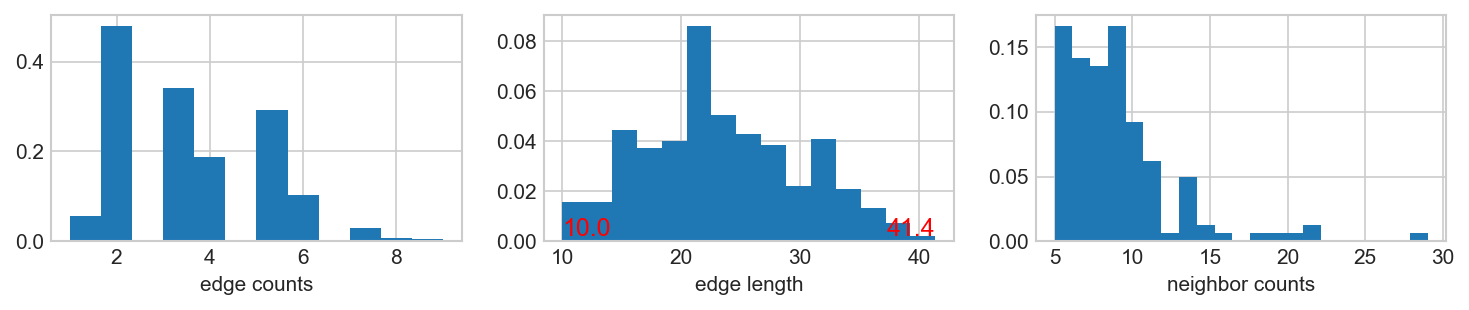

In [51]:
in_file_name: str =robot_folder+"shank_front.step"
out_file_name: str =robot_folder+"shank_front.msh"

vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,gui=show_gui)
vmeshSummary(vmesh)

# vertices          = 182
# surface triangle  = 316
# tetra             = 498
# unique tetra edges= 837
# unique face edges = 474
COM                 =  [  0.044   8.903 -89.476]
COM norm            = 89.918
mean edge length    = 25.97


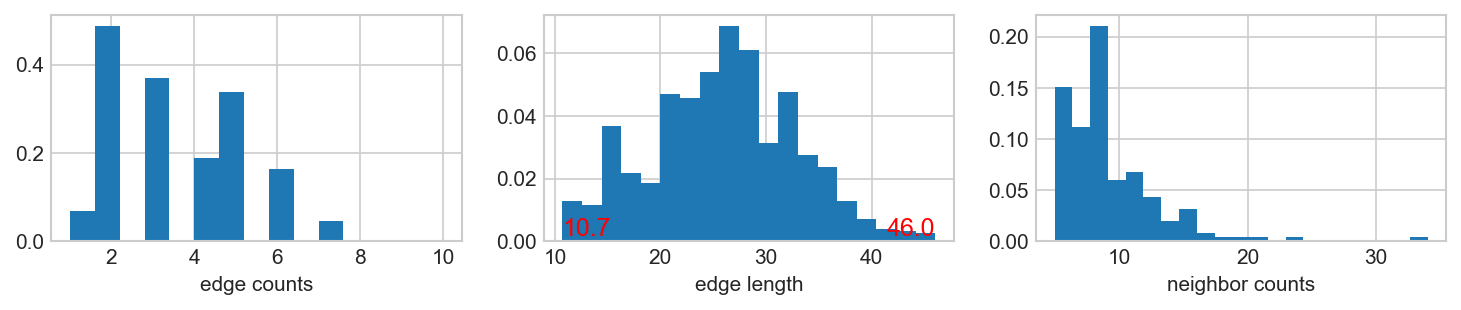

In [52]:
in_file_name: str =robot_folder+"shank_back.step"
out_file_name: str =robot_folder+"shank_back.msh"

vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,gui=show_gui)
vmeshSummary(vmesh)

# vertices          = 146
# surface triangle  = 252
# tetra             = 407
# unique tetra edges= 678
# unique face edges = 378
COM                 =  [  0.167   0.015 -78.998]
COM norm            = 78.998
mean edge length    = 25.66


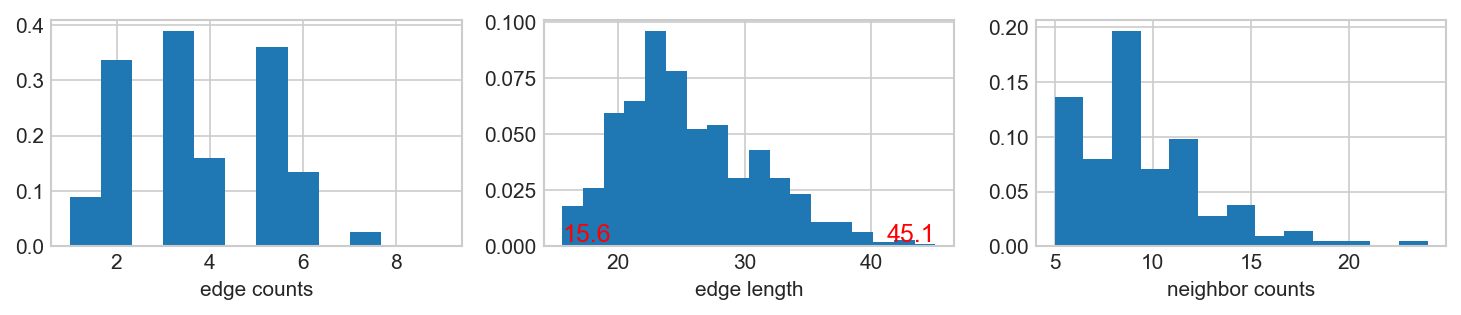

In [53]:
in_file_name: str =robot_folder+"thigh.step"
out_file_name: str =robot_folder+"thigh.msh"

vmesh,_= generateGmsh(in_file_name,out_file_name,gmsh_args=gmsh_args,gmsh_args_3d=gmsh_args_3d,gui=show_gui)
vmeshSummary(vmesh)

# load descritized mesh

# vertices         = 99
# surface triangle = 176
# tetra            = 254
# unique edges     = 960


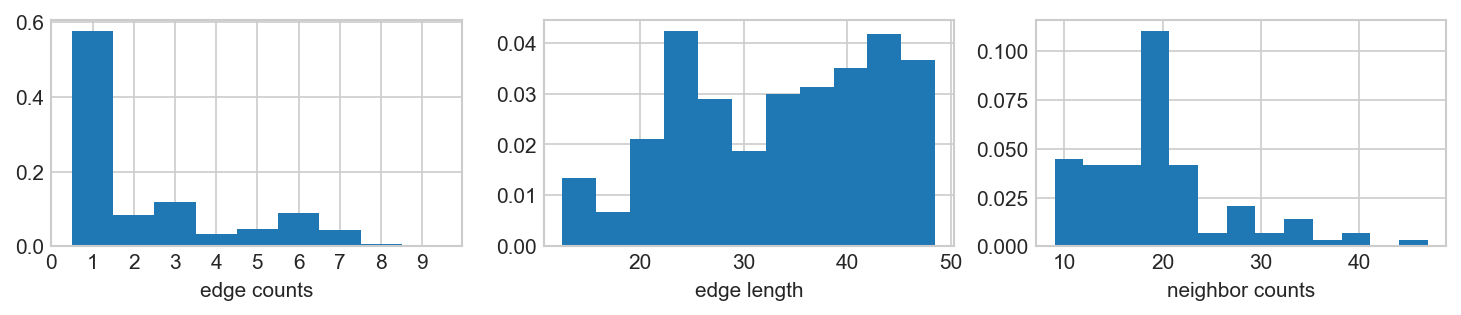

# vertices         = 99
# surface triangle = 176
# tetra            = 252
# unique edges     = 965


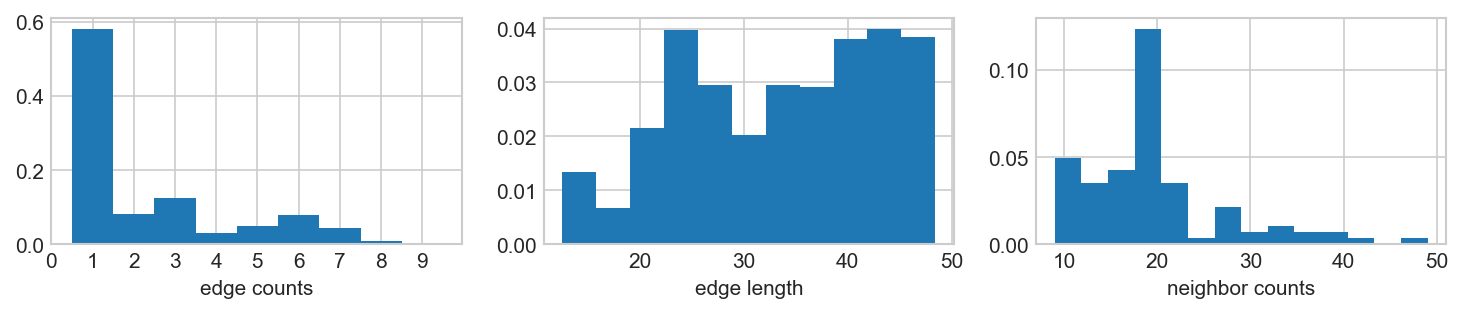

# vertices         = 100
# surface triangle = 176
# tetra            = 266
# unique edges     = 1004


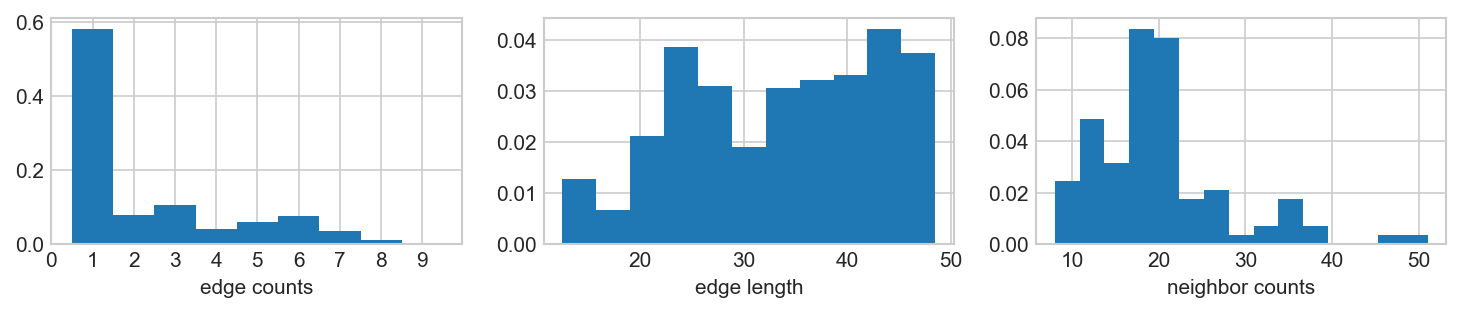

# vertices         = 142
# surface triangle = 266
# tetra            = 370
# unique edges     = 1579


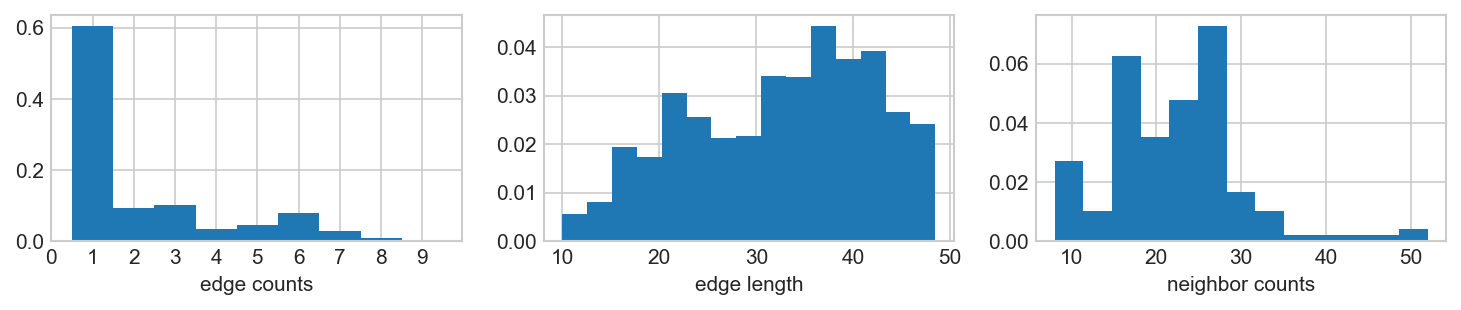

# vertices         = 182
# surface triangle = 316
# tetra            = 498
# unique edges     = 1790


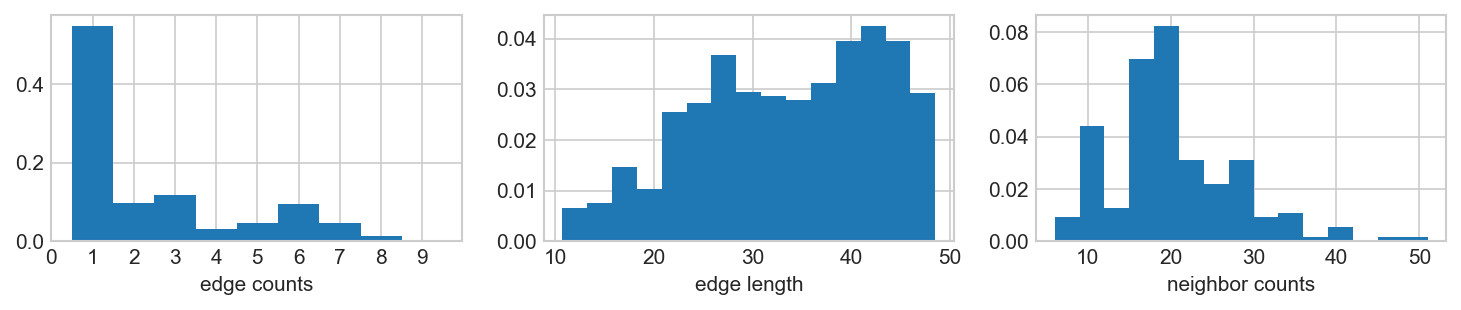

# vertices         = 146
# surface triangle = 252
# tetra            = 407
# unique edges     = 1398


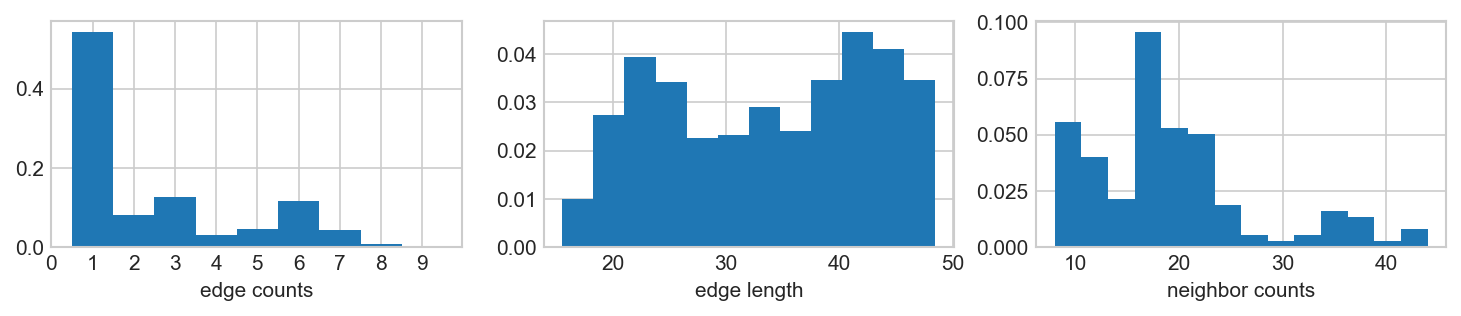

# vertices         = 694
# surface triangle = 1330
# tetra            = 2015
# unique edges     = 7527


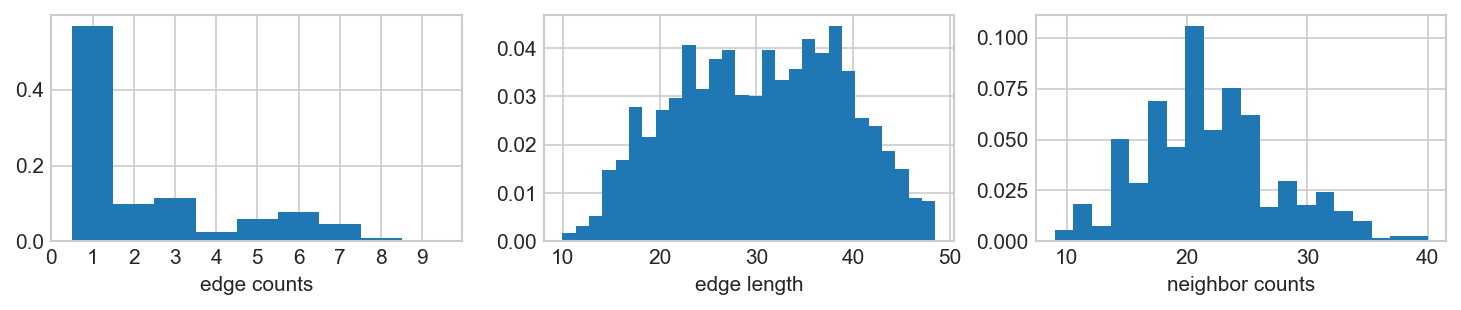

In [54]:
vmd_f0 = descretize(
    msh_file=robot_folder+"hip.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4))

vmd_bl0 = descretize(
    msh_file=robot_folder+"hip_back_mirror.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4))

vmd_br0 = descretize(
    msh_file=robot_folder+"hip_back.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4))

vmd_2f = descretize(
    msh_file=robot_folder+"shank_front.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4))
# o3dShow([vmd_2.lsd()])

vmd_2b = descretize(
    msh_file=robot_folder+"shank_back.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4))
# o3dShow([vmd_2.lsd()])

vmd_1 = descretize(
    msh_file=robot_folder+"thigh.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4))

###############################################################
# x: back->front
# y: right->left
# z: down->top
vmd_body = descretize(
    msh_file=robot_folder+"body.msh",
    min_radius=min_radius, max_radius=radius_knn, max_nn=max_nn,transform=np.eye(4))

In [55]:
# vmd = VolumeMesh(vmd_leg.vertices,vmd_leg.lines,vmd_leg.triangles).copy(cmap ='pink')
# o3dShow([vmd.lsd,vmd.pcd])

# Assemble the parts

In [56]:
# unit = Unit({"length":"mm","density":"g/mm^3"})
# unit.toSI("density")

In [68]:
############################ defineing joints geometry
dx_body_f0 = 125.
dy_body_f0 = 82.
dz_body_f0 = 0.

dx_f01 = 60.
dy_f01 = 0.
dz_f01 = 0.

dx_f12 = 0.
dy_f12 = 0.
dz_f12 = 130.

dx_body_b0 = 125.
dy_body_b0 = 49.
dz_body_b0 = 0.

dx_b01 = 60.
dy_b01 = 0.
dz_b01 = 0.

dx_b12 = 0.
dy_b12 = 0.
dz_b12 = 130.

tlf_body_0 = translation((+dx_body_f0,+dy_body_f0,+dz_body_f0))\
.dot(axisAngleRotation((0, 0, 1),np.pi/2))# front left hip
tlf_0_1 = translation((+dx_f01,-dy_f01,dz_f01))\
.dot(axisAngleRotation((0, 0, 1),-np.pi/2))# front left thigh 
tlf_1_2 = translation((+dx_f12,+dy_f12,-dz_f12))\
.dot(axisAngleRotation((0, 0, 1),-np.pi/2))# front left shank

trf_body_0 = translation((+dx_body_f0,-dy_body_f0,+dz_body_f0))\
                .dot(axisAngleRotation((0, 0, 1),-np.pi/2))# front right hip
trf_0_1 = translation((+dx_f01,+dy_f01,dz_f01))\
                .dot(axisAngleRotation((0, 0, 1), np.pi/2))# front right thigh 
trf_1_2 = translation((+dx_f12,+dy_f12,-dz_f12))\
                .dot(axisAngleRotation((0, 0, 1),-np.pi/2))# front right shank

tlb_body_0 = translation((-dx_body_b0,+dy_body_b0,+dz_body_b0))\
                .dot(axisAngleRotation((0, 0, 1),np.pi/2))# back left hip
tlb_0_1 = translation((+dx_b01,+dy_b01,-dz_b01))\
                .dot(axisAngleRotation((0, 0, 1),np.pi/2))# back left thigh 
tlb_1_2 = translation((+dx_b12,+dy_b12,-dz_b12))\
                .dot(axisAngleRotation((0, 0, 1),np.pi/2))# back left shank

trb_body_0 = translation((-dx_body_b0,-dy_body_b0,+dz_body_b0))\
.dot(axisAngleRotation((0, 0, 1),-np.pi/2))# back right hip
trb_0_1 = translation((+dx_b01,-dy_b01,-dz_b01))\
.dot(axisAngleRotation((0, 0, 1),-np.pi/2))# back right thigh 
trb_1_2 = translation((+dx_b12,-dy_b12,-dz_b12))\
.dot(axisAngleRotation((0, 0, 1),np.pi/2))# back right shank


{0: 'body', 1: 'lf_hip', 2: 'lf_thigh', 3: 'lf_shank', 4: 'rf_hip', 5: 'rf_thigh', 6: 'rf_shank', 7: 'lb_hip', 8: 'lb_thigh', 9: 'lb_shank', 10: 'rb_hip', 11: 'rb_thigh', 12: 'rb_shank'}
{0: ('body', 'lf_hip'), 1: ('body', 'rf_hip'), 2: ('body', 'lb_hip'), 3: ('body', 'rb_hip'), 4: ('lf_hip', 'lf_thigh'), 5: ('lf_thigh', 'lf_shank'), 6: ('rf_hip', 'rf_thigh'), 7: ('rf_thigh', 'rf_shank'), 8: ('lb_hip', 'lb_thigh'), 9: ('lb_thigh', 'lb_shank'), 10: ('rb_hip', 'rb_thigh'), 11: ('rb_thigh', 'rb_shank')}
0 ('body', 'lf_hip')
1 ('body', 'rf_hip')
2 ('body', 'lb_hip')
3 ('body', 'rb_hip')
4 ('lf_hip', 'lf_thigh')
5 ('lf_thigh', 'lf_shank')
6 ('rf_hip', 'rf_thigh')
7 ('rf_thigh', 'rf_shank')
8 ('lb_hip', 'lb_thigh')
9 ('lb_thigh', 'lb_shank')
10 ('rb_hip', 'rb_thigh')
11 ('rb_thigh', 'rb_shank')


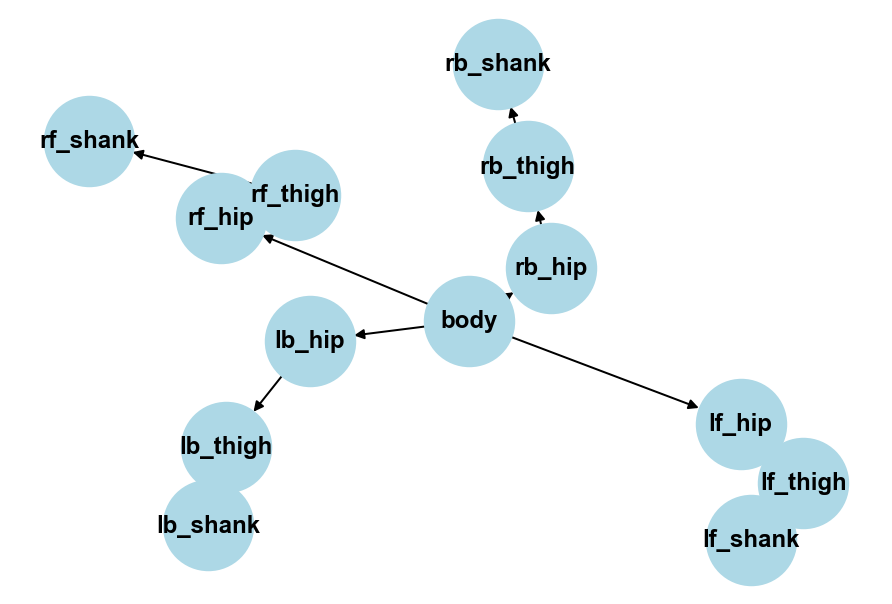

In [69]:
graph = RobotDescription(unit_dict={"length":"mm"})
graph.add_nodes_from([
    ("body", {"vmd": vmd_body.copy(cmap ='RdGy')}),  # main_body
    ("lf_hip", {"vmd": vmd_f0.copy(cmap ='spring')}),  # front left
    ("lf_thigh", {"vmd": vmd_1.copy(cmap ='spring')}),
    ("lf_shank", {"vmd": vmd_2f.copy(cmap ='spring')}), 
    
    ("rf_hip", {"vmd": vmd_f0.copy(cmap ='summer')}),  # front right
    ("rf_thigh", {"vmd": vmd_1.copy(cmap ='summer')}),
    ("rf_shank", {"vmd": vmd_2f.copy(cmap ='summer')}),
    
    ("lb_hip", {"vmd": vmd_bl0.copy(cmap ='autumn')}),  # back left
    ("lb_thigh", {"vmd": vmd_1.copy(cmap ='autumn')}),
    ("lb_shank", {"vmd": vmd_2b.copy(cmap ='autumn')}),
    
    ("rb_hip", {"vmd": vmd_br0.copy(cmap ='winter')}),  # back right
    ("rb_thigh", {"vmd": vmd_1.copy(cmap ='winter')}),
    ("rb_shank", {"vmd": vmd_2b.copy(cmap ='winter')}),
],
    transform = np.eye(4),
    density = 176.,
    color = np.array((1,1,1,1)) # white
)
#graph.nodes['body']['density'] = 100


graph.add_edges_from((
    ("body", "lf_hip", {"transform": tlf_body_0, "joint_pos": 0}),
    ("lf_hip", "lf_thigh", {"transform": tlf_0_1, "joint_pos": 0}),
    ("lf_thigh", "lf_shank", {"transform": tlf_1_2, "joint_pos": 0}),
    
    ("body", "rf_hip", {"transform": trf_body_0, "joint_pos": 0}),
    ("rf_hip", "rf_thigh", {"transform": trf_0_1, "joint_pos": 0}),
    ("rf_thigh", "rf_shank", {"transform": trf_1_2, "joint_pos": 0}),
    
    ("body", "lb_hip", {"transform": tlb_body_0, "joint_pos": 0}),
    ("lb_hip", "lb_thigh", {"transform": tlb_0_1, "joint_pos": 0}),
    ("lb_thigh", "lb_shank", {"transform": tlb_1_2, "joint_pos": 0}),
    
    ("body", "rb_hip", {"transform": trb_body_0, "joint_pos": 0}),
    ("rb_hip", "rb_thigh", {"transform": trb_0_1, "joint_pos": 0}),
    ("rb_thigh", "rb_shank", {"transform": trb_1_2, "joint_pos": 0}),
),
    transform=np.eye(4),
    joint_type="revolute",
    joint_pos=0, 
    axis=(1, 0, 0),
    limit = { # units must be SI here
        "effort":11, # torque, [Nm]
        "velocity":round(487/60*2*np.pi) # speed [rad/s]
    }
)

# create coordinate in body space
graph.createCoordinateOXYZ(radius=15)

nx.draw(graph,nx.spring_layout(graph,iterations=100,threshold=0.0001,k=3/np.sqrt(graph.order())),
        with_labels=True, font_weight='bold',node_size=2000,node_color="lightblue")
################## computed value ###################################
graph.updateWorldTransform()
# list(nx.edge_bfs(graph))

#####################################################################
dict_id2node = dict(enumerate(graph.nodes)) # dict of index to node
dict_node2id = dict(zip(graph.nodes, range(len(graph.nodes)))) # dict of node to index
print(dict_id2node)
dict_id2edge = dict(enumerate(graph.edges)) # dict of index to edges
dict_edge2id = dict(zip(graph.edges, range(len(graph.edges))))
print(dict_id2edge)

for k,e in enumerate(graph.edges):
    print(k,e)

In [70]:
# graph.joint_pos = np.array([-np.pi/2,-np.pi/2,-np.pi/2,-np.pi/2])

#graph.joint_pos = np.array([7 * np.pi/4, np.pi/4, -np.pi/3, np.pi/3, 0, np.pi/3, 0, -np.pi/3, 0, 0, 0, 0])
# graph.joint_pos = np.array([4 * np.pi / 5, 4 * np.pi/3, np.pi/3, 3 * np.pi/2,\
#                             0, np.pi / 2, 0, 3 * np.pi / 2, 0, 11 * np.pi / 6, 0, np.pi / 6])

# graph.joint_pos = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# graph.joint_pos = np.array([np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 0, 0, 0, 0, 0, 0, 0, 0])

alpha = np.pi*0.0
beta = np.pi*0.0

arm_angle = np.pi/2
graph.joint_pos = np.array([ np.pi / 2,           # 0
                            -np.pi / 2,           # 1
                             np.pi / 2 - alpha,   # 2 
                             alpha - np.pi / 2,   # 3 
                             0+arm_angle,         # 4  
                             0-beta,              # 5 
                             0-arm_angle,         # 6     
                             0+beta,              # 7   
                             0,                   # 8 
                             -alpha,               # 9        
                             0,                   # 10 
                             2 * np.pi- alpha     # 11   
                           ])     

graph.updateWorldTransform(t = axisAngleRotation((0, 0, 1),np.pi/2)) #TODO MAKE IT RIGHT
# graph.updateWorldTransform()

world_space_pcds = [o3d.geometry.PointCloud(graph.nodes[n]["vmd"].pcd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_lsd = [o3d.geometry.LineSet(graph.nodes[n]["vmd"].lsd()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]

world_space_o3dMesh = [o3d.geometry.TriangleMesh(graph.nodes[n]["vmd"].o3dMesh()).transform(
    graph.nodes[n]["world_transform"]) for n in graph.nodes]



link_coordinate_frames = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.nodes[n]["world_transform"])for n in graph.nodes]

joint_coordiate_frams = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=50).transform(graph.edges[e]["world_transform"])for e in graph.edges]

# o3dShow(world_space_pcds+world_space_lsd+link_coordinate_frames+joint_coordiate_frams + [coord_frame])

###############################################
discretization_opt = dict(
    min_radius=min_radius, 
    max_radius=radius_knn, 
    max_nn=max_nn,
    joint_radius = 40.,
    joint_height = 40.,
    joint_sections = 30, # number of sections of the joint cylinder mesh
    gmsh_args=gmsh_args,
    gmsh_args_3d=gmsh_args_3d,
)

# number of attachment lines per point in the attached coordinates
num_attach_per_coord = 25


graph = graph.makeJoint(opt=discretization_opt)
#################################################

joint_cylinders = [o3d.geometry.TriangleMesh(graph.edges[e]["cylinder_parent"].o3dMesh()).transform(
    graph.nodes[e[0]]["world_transform"]) for e in graph.edges]
# o3dShow(world_space_pcds[0:]+world_space_lsd[0:]+world_space_o3dMesh[0:]+joint_cylinders[0:])#+link_coordinate_frames+joint_coordiate_frams)
o3dShow(world_space_pcds[0:]+world_space_lsd[0:]+joint_cylinders[0:])#+link_coordinate_frames+joint_coordiate_frams)

# robot_lsd = o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(vertices),
#     o3d.utility.Vector2iVector(lines))
# robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))
# o3dShow([robot_lsd]+joint_cylinders[0:])

('body', 'lf_hip'):39,39
('body', 'rf_hip'):39,39
('body', 'lb_hip'):39,39
('body', 'rb_hip'):39,39
('lf_hip', 'lf_thigh'):39,39
('lf_thigh', 'lf_shank'):39,39
('rf_hip', 'rf_thigh'):39,39
('rf_thigh', 'rf_shank'):39,39
('lb_hip', 'lb_thigh'):39,39
('lb_thigh', 'lb_shank'):39,39
('rb_hip', 'rb_thigh'):39,39
('rb_thigh', 'rb_shank'):39,39
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


# create spring-mass representation

id_vertices=[   0  844 1012 1221 1398 1566 1776 1953 2121 2330 2546 2714 2923 3139
 3163 3338]
id_vertices labels:
('body', 0)
('lf_hip', 844)
('lf_thigh', 1012)
('lf_shank', 1221)
('rf_hip', 1398)
('rf_thigh', 1566)
('rf_shank', 1776)
('lb_hip', 1953)
('lb_thigh', 2121)
('lb_shank', 2330)
('rb_hip', 2546)
('rb_thigh', 2714)
('rb_shank', 2923)
('anchor', 3139)
('coord', 3163)
('end', 3338)
--------------------
id_lines=[    0 10942 13369 16036 18327 20748 23446 25737 28152 30806 33304 35717
 38371 40869 40881 42753 51865 52390 56765]
id_lines labels:
(('body', 'lf_hip'), 0)
(('body', 'rf_hip'), 10942)
(('body', 'lb_hip'), 13369)
(('body', 'rb_hip'), 16036)
(('lf_hip', 'lf_thigh'), 18327)
(('lf_thigh', 'lf_shank'), 20748)
(('rf_hip', 'rf_thigh'), 23446)
(('rf_thigh', 'rf_shank'), 25737)
(('lb_hip', 'lb_thigh'), 28152)
(('lb_thigh', 'lb_shank'), 30806)
(('rb_hip', 'rb_thigh'), 33304)
(('rb_thigh', 'rb_shank'), 35717)
('anchor_lines', 40869)
('rot_springs', 40881)
('fri_springs', 42753)
(

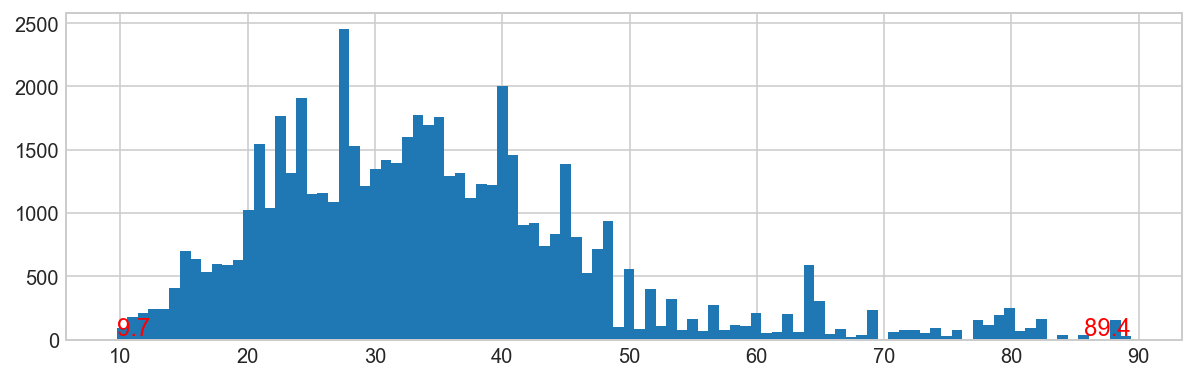

In [67]:
graph.updateWorldTransform()

# ##################################################
part_vertices = [applyTransform(graph.nodes[n]["vmd"].vertices,
                                graph.nodes[n]["world_transform"]) for n in graph.nodes]
anchor_vertices = [applyTransform(graph.edges[e]['anchor'],
                                  graph.edges[e]["world_transform"]) for e in graph.edges]
part_coord_vertices = [applyTransform(graph.nodes[n]['coord'],
                                      graph.nodes[n]["world_transform"]) for n in graph.nodes]
joint_coord_vertices = [applyTransform(graph.edges[e]['coord'],
                                       graph.edges[e]["world_transform"]) for e in graph.edges]

# vertices:
# parts_xyzs = part_k_xyzs for k in range(#nodes)
# anchors_xyzs = anchor_k for k in range(#joints)
# coord_xys = coord(root_node), coord(joint_k_left),coord(joint_k_right), k in range(#joints)
# vertices = np.vstack(part_vertices + 
#                      anchor_vertices +
#                      part_coord_vertices + 
#                      joint_coord_vertices)

vertices = part_vertices + \
    [np.vstack(anchor_vertices)] +\
    [np.vstack(part_coord_vertices+joint_coord_vertices)]
id_vertices = np.hstack(([0], np.cumsum([len(v) for v in vertices])))
vertices = np.vstack(vertices)

id_vertices_label = [(n, id_vertices[k]) for k, n in enumerate(graph.nodes)] + \
    [("anchor", id_vertices[len(graph)]),
     ("coord", id_vertices[len(graph)+1]),
     ("end", id_vertices[len(graph)+2])]

# colors of the vertices
part_colors = np.vstack(
    [graph.nodes[n]["vmd"]["vertices_color"] for n in graph.nodes])
colors = np.zeros((len(vertices), 3))
colors[:len(part_colors)] = part_colors


###################################################################
part_len = [len(v) for v in part_vertices]
anchor_len = [len(v) for v in anchor_vertices]
part_coord_len = [len(v) for v in part_coord_vertices]
joint_coord_len = [len(v) for v in joint_coord_vertices]

# id_vertices = np.hstack(
#     ([0], np.cumsum(part_len+anchor_len+part_coord_len+joint_coord_len)))

# vertex ids
vid_part = np.hstack(([0], np.cumsum(part_len)))  # vertex id part
vid_anchor = np.hstack(([0], np.cumsum(anchor_len))) + \
    vid_part[-1]  # vertex id anchor
vid_part_coord = np.hstack(([0], np.cumsum(part_coord_len))) + vid_anchor[-1]
vid_joint_coord = np.hstack(
    ([0], np.cumsum(joint_coord_len))) + vid_part_coord[-1]

for k, n in enumerate(graph.nodes):
    graph.nodes[n]["vertex_start_id"] = vid_part[k]
    graph.nodes[n]["coord_start_id"] = vid_part_coord[k]
for k, e in enumerate(graph.edges):
    graph.edges[e]["coord_start_id"] = vid_joint_coord[k]
    graph.edges[e]["anchor_start_id"] = vid_anchor[k]
############################################################
# part surfaces
part_surface_id = np.hstack(
    [np.unique(graph.nodes[n]["vmd"]["triangles"].ravel()) +
     graph.nodes[n]["vertex_start_id"] for n in graph.nodes])
is_surface = np.zeros(len(vertices), dtype=bool)
is_surface[part_surface_id] = True

###############################################################
part_triangles = [graph.nodes[n]["vmd"].triangles +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

triangles = np.vstack(part_triangles)
###############################################################
part_lines = [graph.nodes[n]["vmd"].lines +
              graph.nodes[n]["vertex_start_id"] for n in graph.nodes]

anchor_lines = [(graph.edges[e]["anchor_start_id"],
                 graph.edges[e]["anchor_start_id"]+1) for e in graph.edges]

part_coord_self_lines = [graph.nodes[n]["coord_start_id"] +
                         graph.nodes[n]["coord_self_lines"] for n in graph.nodes]
joint_coord_self_lines = [graph.edges[e]["coord_start_id"] +
                          graph.edges[e]["coord_self_lines"] for e in graph.edges]


# connecting coordinate to the body parts
part_coord_attach_lines = []
for k, n in enumerate(graph.nodes):
    part_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[k],
                  right_vertices=part_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[k],
                  right_id_start=vid_part_coord[k]))

# connecting coordinate to the joint-parent
joint_coord_attach_lines = []
for k, e in enumerate(graph.edges):
    parent_id = dict_node2id[e[0]]
    joint_coord_attach_lines.append(
        joinLines(left_vertices=part_vertices[parent_id],  # parent vertices
                  right_vertices=joint_coord_vertices[k],
                  max_nn=num_attach_per_coord, min_radius=min_radius, max_radius=radius_knn*10,
                  left_id_start=vid_part[parent_id],
                  right_id_start=vid_joint_coord[k]))


joints = []

for k, e in enumerate(graph.edges):
    edge = graph.edges[e]
    parent = e[0]
    child = e[1]
    parent_id = dict_node2id[e[0]]
    child_id = dict_node2id[e[1]]
    joint_k = Joint(
        left=edge["id_joint_parent"]+vid_part[parent_id],
        right=edge["id_joint_child"]+vid_part[child_id],
        anchor=anchor_lines[k],
        left_coord=edge["coord_start_id"],
        right_coord=graph.nodes[child]["coord_start_id"],
        axis=edge["axis"]
    )
    lines_length = np.linalg.norm(vertices[joint_k.friSpring[:, 0]] -
                                  vertices[joint_k.friSpring[:, 1]], axis=1)
    joint_k.friSpring = joint_k.friSpring[lines_length > 0.3*radius_knn]
    joints.append(joint_k)

rot_springs = [j.rotSpring for j in joints]
fri_springs = [j.friSpring for j in joints]

# lines:
# parts_lines = part_k_lines for k in range(#nodes)
# anchors_lines
# oxyz_self_springs
# oxyz_anchor_springs
# rotation springs
# resetable friction springs

coord_self_lines = part_coord_self_lines+joint_coord_self_lines
coord_attach_lines = part_coord_attach_lines+joint_coord_attach_lines

lines = part_lines +\
    [np.vstack(anchor_lines)] +\
    [np.vstack(rot_springs)] +\
    [np.vstack(fri_springs)] +\
    [np.vstack(coord_self_lines)] +\
    [np.vstack(coord_attach_lines)]

# start, end of respective lines
id_lines = np.hstack(([0], np.cumsum([len(v) for v in lines])))

lines = np.vstack(lines)

id_lines_label = [(n, id_lines[k]) for k, n in enumerate(graph.edges)] + \
    [("anchor_lines", id_lines[len(graph)]),
     ("rot_springs", id_lines[len(graph)+1]),
     ("fri_springs", id_lines[len(graph)+2]),
     ("coord_self_lines", id_lines[len(graph)+3]),
     ("coord_attach_lines", id_lines[len(graph)+4]),
     ("end", id_lines[len(graph)+5])]

print(f"id_vertices={id_vertices}")
print("id_vertices labels:",*id_vertices_label,"-"*20, sep = "\n")

print(f"id_lines={id_lines}")
print("id_lines labels:",*id_lines_label,"-"*20, sep = "\n")

lines_length = np.linalg.norm(vertices[lines[:,0]] - vertices[lines[:,1]],axis=1)
plt.figure(figsize=(10,3))
n,bins,_ =plt.hist(lines_length,bins="auto")
plt.text(bins[0],0,f"{bins[0]:.1f}",ha="left",va="bottom",fontsize="large",color='r')
plt.text(bins[-1],0,f"{bins[-1]:.1f}",ha="right",va="bottom",fontsize="large",color='r')

plt.show()

In [18]:
# o3dShow(robot_lsd)
# export
xyz_all_trans = vertices.copy()

xyz_all_trans = applyTransform(xyz_all_trans,axisAngleRotation((0, 1, 0),-np.pi/2))

min_bound = xyz_all_trans.min(axis=0)
# transoformed ofset scaled mm->m
xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]+-1]))/1000


joints_list = [joint.tolist() for joint in joints]

data = [
    radius_poisson*1e-3,# convert to m
    xyz_all_trans.tolist(),
    lines.tolist(),
    triangles.tolist(),
    is_surface.tolist(),
    id_vertices.tolist(),
    id_lines.tolist(),
    colors.tolist(),
    joints_list
]

print(xyz_all_trans.min(axis=0))
print(xyz_all_trans.max(axis=0))
print(xyz_all_trans.shape)
print(lines.shape)


# robot_lsd = o3d.geometry.LineSet(
#     o3d.utility.Vector3dVector(xyz_all_trans),
#     o3d.utility.Vector2iVector(lines))
# robot_lsd.colors = o3d.utility.Vector3dVector(colors[lines].mean(axis=1))
# o3dShow([robot_lsd,o3d.geometry.TriangleMesh.create_coordinate_frame(
#     size=0.1, origin=[0, 0, 0])])

# https://stackoverflow.com/questions/43442194/how-do-i-read-and-write-with-msgpack
# Write msgpack file
with open('../flexipod_12dof.msgpack', 'wb') as outfile:
    msgpack.pack(data, outfile)
    
# # Read msgpack file
# with open('../data.msgpack','rb') as data_file:
#     # data_loaded = json.load(data_file)
#     data_loaded = msgpack.unpack(data_file)

[-0.1006979 -0.452     -0.001    ]
[0.09308401 0.452      0.63529235]
(3346, 3)
(57025, 2)


##  generate URDF

In [118]:
urdf_path = "../../data/urdf/test/robot.urdf"
graph.exportURDF(path= urdf_path)

URDF path:D:\repo\experimental_flexipod\data\urdf\test\robot.urdf

<?xml version='1.0' encoding='ASCII'?>
<robot name="robot">
  <link name="body">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="0.47751128221262107"/>
      <inertia ixx="0.0012178446803329972" ixy="4.947414618022251e-07" ixz="-1.7132693213723168e-08" iyy="0.005483693521775224" iyz="1.602928575352216e-07" izz="0.005962692302973817"/>
    </inertial>
    <visual>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/body.obj"/>
      </geometry>
      <material name="#ffffffff">
        <color rgba="1 1 1 1"/>
      </material>
    </visual>
    <collision>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <geometry>
        <mesh filename="mesh/body.obj"/>
      </geometry>
    </collision>
  </link>
  <link name="lf_hip">
    <inertial>
      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>
      <mass value="0.079661640935815"/>
  

In [26]:
import numpy as np
import pybullet as p
import time
import pybullet_data
##########################################
urdf_path = "../../data/urdf/test/robot.urdf"
####################################################

gui = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=gui)
p.setGravity(0, 0, -10)
robot_id = p.loadURDF(urdf_path, [0, 0, 0.5], physicsClientId=gui)
plane = p.loadURDF("plane.urdf")

# # ##################################################
while (p.getConnectionInfo(physicsClientId=gui)["isConnected"]):
    #p.setJointMotorControlArray(robot_id,np.arange(p.getNumJoints(robot_id)),p.POSITION_CONTROL,joint_pos)
    p.stepSimulation(physicsClientId=gui)
    #time.sleep(0.01)
    
# p.disconnect()

In [27]:
p.disconnect()

error: Not connected to physics server.

In [ ]:
p.getNumJoints(robot_id)

# this part is not ready yet